In [2]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [13]:
file_List = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
file_List = os.path.join(os.path.dirname(file_List), "ModelNet10")

In [14]:
def data(point=1024):

    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    class_map = {}
    Dir = glob.glob(os.path.join(file_List, "[!README]*"))

    for i, folder in enumerate(Dir):
        print("category: {}".format(os.path.basename(folder)))
       
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_list = glob.glob(os.path.join(folder.split('/n')[0], "train/*"))
        test_list = glob.glob(os.path.join(folder.split('/n')[0], "test/*"))

        for file in train_list:
            train_data.append(trimesh.load(file).sample(point))
            train_labels.append(i)

        for file in test_list:
            test_data.append(trimesh.load(file).sample(point))
            test_labels.append(i)

    return (
        np.array(train_data),
        np.array(test_data),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [15]:
train_data, test_data, train_labels, test_labels, CLASS_MAP = data(
    1024
)

category: bathtub
category: bed
category: chair
category: night_stand
category: sofa
category: table
category: toilet


In [89]:
def jet(Data, label):
    
    Data += tf.random.uniform(Data.shape, -0.005, 0.005, dtype=tf.float64)

    Data = tf.random.shuffle(Data)
    return Data, label


train_list = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_list = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

train_list = train_list.shuffle(len(train_data)).map(augment).batch(BATCH_SIZE)
test_list = test_list.shuffle(len(test_data)).batch(BATCH_SIZE)

In [5]:
NUM_POINTS = 1024
NUM_CLASSES = 10
BATCH_SIZE = 32

input_tensor = keras.Input(shape=(NUM_POINTS, 3))

x = layers.Conv1D(8, 3, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(pool_size=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(16, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(pool_size=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(32, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(pool_size=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(64, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(pool_size=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(pool_size=3)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_tensor = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    
model = tf.keras.Model(input_tensor, output_tensor)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024, 3)]         0         
                                                                 
 conv1d_10 (Conv1D)          (None, 1022, 8)           80        
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 340, 8)           0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 340, 8)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 338, 16)           400       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 112, 16)          0         
 g1D)                                                      

In [4]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [72]:
history= model.fit(train_list, epochs=10, validation_data=test_list)

Epoch 1/10
98/98 [==============================] - 135s 1s/step - loss: 3.3478 - sparse_categorical_accuracy: 0.3385 - val_loss: 6641319204093952.0000 - val_sparse_categorical_accuracy: 0.3270
Epoch 2/10
98/98 [==============================] - 124s 1s/step - loss: 2.7273 - sparse_categorical_accuracy: 0.4549 - val_loss: 1343794433108350058102784.0000 - val_sparse_categorical_accuracy: 0.3821
Epoch 3/10
98/98 [==============================] - 125s 1s/step - loss: 2.4947 - sparse_categorical_accuracy: 0.5301 - val_loss: 499768.0625 - val_sparse_categorical_accuracy: 0.4104
Epoch 4/10
98/98 [==============================] - 126s 1s/step - loss: 2.3359 - sparse_categorical_accuracy: 0.5905 - val_loss: 350651678485118976.0000 - val_sparse_categorical_accuracy: 0.6918
Epoch 5/10
98/98 [==============================] - 124s 1s/step - loss: 2.2117 - sparse_categorical_accuracy: 0.6536 - val_loss: 2923264844552982233088.0000 - val_sparse_categorical_accuracy: 0.5503
Epoch 6/10
98/98 [=====

1/1 [==============================] - 0s 54ms/step


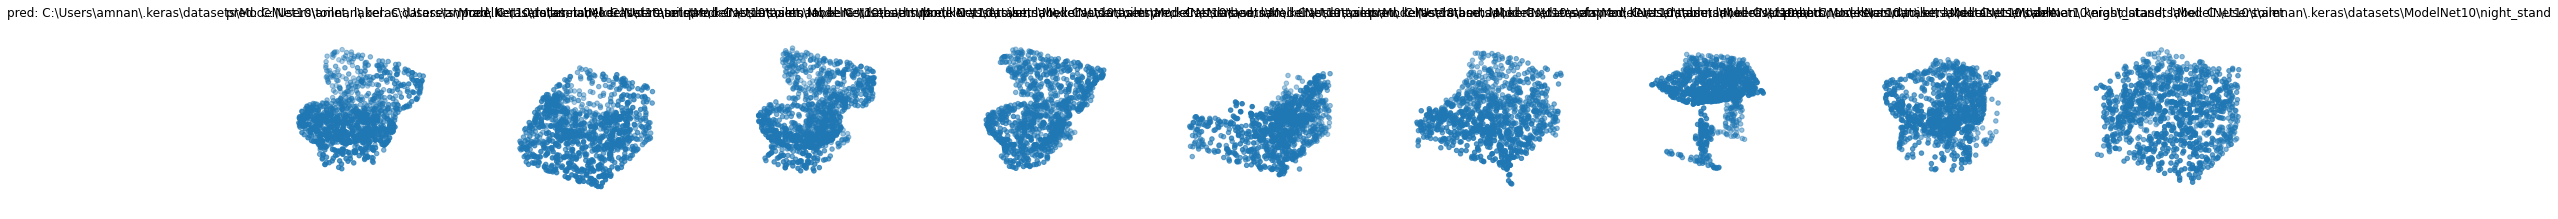

In [80]:
item = test_list

data, labels = list(item)[0]
data = data[:10, ...]
labels = labels[:10, ...]

pred = model.predict(data)
pred = tf.math.argmax(pred, -1)

data = data.numpy()
fig = plt.figure(figsize=(40, 20))
for i in range(9):
    ax = fig.add_subplot(1, 10, i + 1, projection="3d")
    ax.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[pred[i].numpy()], CLASS_MAP[labels[i].numpy()]
        )
    )
    ax.set_axis_off()
plt.show()


In [85]:
score = model.evaluate(test_data, test_labels, verbose=0)
print("Test accuracy:", score[1])

Test accuracy: 0.8254716992378235


Text(0.5, 1.0, 'Accuracy Curves')

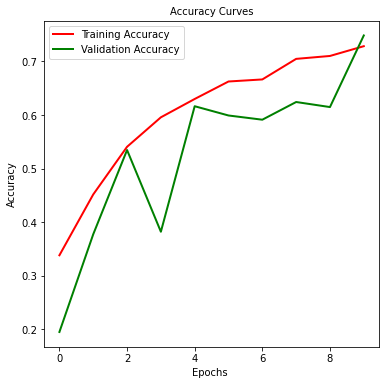

In [54]:
# Accuracy Curves
plt.figure(figsize=[6,6])
plt.plot(history.history['sparse_categorical_accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_sparse_categorical_accuracy'],'g',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.title('Accuracy Curves',fontsize=10)